# Auxiliary_Rotation Attack (with Translation)

# import necessary dependencies
import argparse
import os, sys
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms as trn
import torchvision.transforms.functional as trnF
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
from torchvision import datasets
from torchsummary import summary
from torch.autograd import Variable
import PIL
from PIL import Image
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter
import random
import pandas as pd
import torch.backends.cudnn as cudnn
import opencv_functional as cv2f

!pip install "opencv-python-headless<4.3"
#conda install pillow=6.1
print('Architecture List:')
print(torch.cuda.get_arch_list())
random.seed(10)
print(random.random())
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')

from torchvision.utils import save_image
from tqdm import tqdm
import sklearn.metrics as sk
import itertools
import pdb
import cv2


# Residual block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self,x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x.to(device))))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out
    
    
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, numBlocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1   = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1     = nn.BatchNorm2d(16)
        self.layer1  = self.make_layer(block, 16, numBlocks[0], stride=1)
        self.layer2  = self.make_layer(block, 32, numBlocks[1], stride=2)
        self.layer3  = self.make_layer(block, 64, numBlocks[2], stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc1     = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, numBlocks, stride):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, numBlocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0),-1)
        #out = self.fc1(out)
        return self.fc1(out),out


#------------------ Data loaders: Train Validation, test and Corrpted data loader#######################################
normalize     = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
randomly_crop = transforms.RandomCrop(32,padding=4)


class PerturbDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, train_mode=True):
        self.dataset = dataset
        self.num_points = len(self.dataset.data)
        self.train_mode = train_mode

    def __getitem__(self, index):
        x_orig, classifier_target = self.dataset[index]

        if self.train_mode == True and np.random.uniform() < 0.5:
            x_orig = np.copy(x_orig)[:, ::-1]
        else:
            x_orig =  np.copy(x_orig)

        if self.train_mode == True:
            x_orig = Image.fromarray(x_orig)
            x_orig = randomly_crop(x_orig)
            x_orig = np.asarray(x_orig)

        x_tf_0 = np.copy(x_orig)
        x_tf_90 = np.rot90(x_orig.copy(), k=1).copy()
        x_tf_180 = np.rot90(x_orig.copy(), k=2).copy()
        x_tf_270 = np.rot90(x_orig.copy(), k=3).copy()

        #---------------Translation
        possible_translations = list(itertools.product([0, 8, -8], [0, 8, -8]))
        num_possible_translations = len(possible_translations)
        tx, ty = possible_translations[random.randint(0, num_possible_translations - 1)]
        tx_target = {0: 0, 8: 1, -8: 2}[tx]
        ty_target = {0: 0, 8: 1, -8: 2}[ty]
        x_tf_trans = cv2f.affine(np.asarray(x_orig).copy(), 0, (tx, ty), 1, 0, interpolation=cv2.INTER_CUBIC, mode=cv2.BORDER_REFLECT_101)

        return \
            normalize(trnF.to_tensor(x_tf_0)), \
            normalize(trnF.to_tensor(x_tf_90)), \
            normalize(trnF.to_tensor(x_tf_180)), \
            normalize(trnF.to_tensor(x_tf_270)), \
            normalize(trnF.to_tensor(x_tf_trans)), \
            torch.tensor(tx_target), \
            torch.tensor(ty_target), \
            torch.tensor(classifier_target)

    def __len__(self):
        return self.num_points
    
    
def test_CIFAR10(net,criterion,root_data_dir,batch_size):
    testset = torchvision.datasets.CIFAR10(root=root_data_dir, train=False, download=True)
    testset   = PerturbDataset(testset, train_mode=False)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = criterion

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (x_tf_0, x_tf_90, x_tf_180, x_tf_270, x_tf_trans, target_trans_x, target_trans_y, target_class) in enumerate(testloader):
            batch_size  = x_tf_0.shape[0]
            batch       = np.concatenate((x_tf_0,x_tf_90,x_tf_180,x_tf_270,x_tf_trans), 0)
            batch       = torch.FloatTensor(batch).cuda()
            target_rots = torch.cat((torch.zeros(batch_size),torch.ones(batch_size),2 * torch.ones(batch_size),3 * torch.ones(batch_size)), 0).long()

            # copy inputs to device
            batch          = batch.to(batch)
            target_class   = target_class.to(device)
            target_rots    = target_rots.to(device)
            target_trans_x = target_trans_x.to(device)
            target_trans_y = target_trans_y.to(device)

            # compute the output and loss
            logits, pen           = net(batch)
            classification_logits = logits[:batch_size]
            rot_logits            = net.rot_head(pen[:4*batch_size])
            x_trans_logits        = net.x_trans_head(pen[4*batch_size:]) 
            y_trans_logits        = net.y_trans_head(pen[4*batch_size:])

            classification_loss   = criterion(classification_logits, target_class)
            rot_loss              = criterion(rot_logits, target_rots)*ROTATION_LOSS_WEIGHT
            x_trans_loss          = criterion(x_trans_logits, target_trans_x.cuda()) * TRANS_LOSS_WEIGHT
            y_trans_loss          = criterion(y_trans_logits, target_trans_y.cuda()) * TRANS_LOSS_WEIGHT
            loss = classification_loss + ((rot_loss + x_trans_loss + y_trans_loss) / 3.0)            

            
            test_loss += loss.item()
            _, predicted = classification_logits.max(1)
            total += target_class.size(0)
            correct += predicted.eq(target_class).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))
    return test_loss / (num_val_steps), val_acc


####################Hyoerperametter###################################
# a few arguments, do NOT change these
DATA_ROOT           = "./data"
CORRUPTED_DATA_ROOT = "/data/usr/ft42/nobackup/CIFAR_10_C/CIFAR-10-C/"
# the folder where the trained model is saved
CHECKPOINT_FOLDER   = "savedFiles/saved_models/"
# the folder where the figures are saved
FIGURES_FOLDER      = "savedFiles/saved_figures/"
# the folder where the csvs are saved
CSVS_FOLDER         = "savedFiles/saved_csvs/"
# name of the saved model
MODELNAME_REG       = "resnet20_RotationLoss"


# GPU check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")


# hyperparameters, do NOT change right now
TRAIN_BATCH_SIZE = 256    # training batch size
VAL_BATCH_SIZE   = 100    # validation batch size
INITIAL_LR       = 0.1    # initial learning rate
MOMENTUM         = 0.9    # momentum for optimizer
REG              = 1e-3   # L2 regularization strength
EPOCHS           = 200    # total number of training epochs
DECAY_EPOCHS     = 20     # parameter for LR schedule (decay after XX epochs)
DECAY            = 0.5    # parameter for LR schedule (decay multiplier)
NUM_OF_ROTATION = [4]
ROTATION_LOSS_WEIGHT = 3.0
TRANS_LOSS_WEIGHT    = 0.0
MODELNAME = MODELNAME_REG+'_{}_rotweight{}_tranlweiht{}'.format(NUM_OF_ROTATION[0],ROTATION_LOSS_WEIGHT,TRANS_LOSS_WEIGHT)


net          = ResNet(ResBlock, [3, 3, 3])
net.x_trans_head = nn.Linear(64, 3)
net.y_trans_head = nn.Linear(64, 3)
net.rot_head     = nn.Linear(64, 4)
net = net.to(device)
net.load_state_dict(torch.load(CHECKPOINT_FOLDER+MODELNAME+'.pt',map_location='cuda:0'))
criterion = nn.CrossEntropyLoss().to(device)
test_loss,test_acc=test_CIFAR10(net,criterion,root_data_dir=DATA_ROOT,batch_size=VAL_BATCH_SIZE)
print(test_loss,test_acc)


# Compute the gradient of the loss w.r.t. the input data
def gradient_wrt_data(net,device,data,target_class,target_rots,target_trans_x,target_trans_y,criterion):
    
    batch_size  = 100
    dat = data.clone().detach()
    dat.requires_grad = True
    logits, pen           = net(dat)
    classification_logits = logits[:batch_size]
    rot_logits            = net.rot_head(pen[:4*batch_size])
    x_trans_logits        = net.x_trans_head(pen[4*batch_size:]) 
    y_trans_logits        = net.y_trans_head(pen[4*batch_size:])
    
    classification_loss   = criterion(classification_logits, target_class)
    rot_loss              = criterion(rot_logits, target_rots)*ROTATION_LOSS_WEIGHT
    x_trans_loss          = criterion(x_trans_logits, target_trans_x.cuda()) * TRANS_LOSS_WEIGHT
    y_trans_loss          = criterion(y_trans_logits, target_trans_y.cuda()) * TRANS_LOSS_WEIGHT
    loss = classification_loss + ((rot_loss + x_trans_loss + y_trans_loss) / 3.0)
    
    
    net.zero_grad()
    loss.backward()
    #print()
    data_grad = dat.grad.data
    return data_grad.data.detach()


def FGSM_attack(model, device, dat, target_class,target_rots,target_trans_x,target_trans_y,eps):
    # TODO: Implement the FGSM attack
    # - Dat and lbl are tensors
    # - eps is a float
    # HINT: FGSM is a special case of PGD
    criterion = nn.CrossEntropyLoss().to(device)
    x_nat = dat.clone().detach()
    # Compute gradient w.r.t. data (we give you this function, but understand it)
    x_grad  = gradient_wrt_data(model,device,data=x_nat,target_class=target_class,target_rots=target_rots,target_trans_x=target_trans_x,target_trans_y=target_trans_y,criterion=criterion)
    # Perturb the image using the gradient
    x_pertured = x_nat.detach() + eps*x_grad.sign()
    #print(x_pertured.shape)
    # Clip the perturbed datapoints to ensure we are in bounds [0,1]
    #print(x_pertured.shape)
    #x_pertured = torch.clamp(x_pertured, min=0, max=1).detach()
    # Return the final perturbed samples
    return x_pertured

testset = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=False, download=True)
testset   = PerturbDataset(testset, train_mode=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)



## Load pretrained models
whitebox = net.to(device)
whitebox.eval()
EPS_Test = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]
print(EPS_Test)


Auxiliary_Rotation_FGSM_acc_list = []


for roi_EPS in EPS_Test:


    # TODO: Set attack parameters here
    ATK_EPS          = roi_EPS
    whitebox_correct = 0.
    running_total    = 0.
    for batch_idx, (x_tf_0, x_tf_90, x_tf_180, x_tf_270, x_tf_trans, target_trans_x, target_trans_y, target_class) in enumerate(testloader):
        batch_size  = 100 #x_tf_0.shape[0]
        batch       = np.concatenate((x_tf_0,x_tf_90,x_tf_180,x_tf_270,x_tf_trans), 0)
        batch       = torch.FloatTensor(batch).cuda()
        target_rots = torch.cat((torch.zeros(batch_size),torch.ones(batch_size),2 * torch.ones(batch_size),3 * torch.ones(batch_size)), 0).long()

        # copy inputs to device
        batch          = batch.to(batch)
        target_class   = target_class.to(device)
        target_rots    = target_rots.to(device)
        target_trans_x = target_trans_x.to(device)
        target_trans_y = target_trans_y.to(device)
        # TODO: Perform adversarial attack here
        #-Within this function model has no influence
        whitebox_adv_data = FGSM_attack(model=whitebox, device=device, dat=batch, 
        target_class=target_class,
        target_rots=target_rots,
        target_trans_x=target_trans_x,
        target_trans_y=target_trans_y,
        eps=ATK_EPS)
        
        '''
        print((torch.max(torch.abs(whitebox_adv_data[1,:,:,:]-batch[1,:,:,:]))))

        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(whitebox_adv_data[100,:,:,:]-batch[100,:,:,:])) <= (ATK_EPS + 1e-5) )
        assert(torch.max(torch.abs(whitebox_adv_data-batch)) <= (ATK_EPS + 1e-5) )
        assert(whitebox_adv_data.max() == 1.)
        assert(whitebox_adv_data.min() == 0.)
        '''
        
        # Compute accuracy on perturbed data
        with torch.no_grad():
            # Stat keeping - whitebox
            logits, pen                 = whitebox(whitebox_adv_data)
            classification_logits       = logits[:batch_size]
            _, predicted = classification_logits.max(1)
            whitebox_correct += predicted.eq(target_class).sum().item()
            running_total += target_class.size(0)

    # Print final 
    whitebox_acc = whitebox_correct/running_total
    Auxiliary_Rotation_FGSM_acc_list.append(whitebox_acc)
    print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

print("Done!")


# Auxiliary_Rotation Attack (without Translation)

In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms as trn
import torchvision.transforms.functional as trnF
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
from torchvision import datasets
from torchsummary import summary
from torch.autograd import Variable
import PIL
from PIL import Image
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter
import random
import pandas as pd
import torch.backends.cudnn as cudnn
import opencv_functional as cv2f

!pip install "opencv-python-headless<4.3"
#conda install pillow=6.1
print('Architecture List:')
print(torch.cuda.get_arch_list())
random.seed(10)
print(random.random())
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')

from torchvision.utils import save_image
from tqdm import tqdm
import sklearn.metrics as sk
import itertools
import pdb
import cv2


# Residual block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self,x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x.to(device))))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out
    
    
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, numBlocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1   = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1     = nn.BatchNorm2d(16)
        self.layer1  = self.make_layer(block, 16, numBlocks[0], stride=1)
        self.layer2  = self.make_layer(block, 32, numBlocks[1], stride=2)
        self.layer3  = self.make_layer(block, 64, numBlocks[2], stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc1     = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, numBlocks, stride):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, numBlocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0),-1)
        #out = self.fc1(out)
        return self.fc1(out),out


#------------------ Data loaders: Train Validation, test and Corrpted data loader#######################################
normalize     = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
randomly_crop = transforms.RandomCrop(32,padding=4)


class PerturbDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, train_mode=True):
        self.dataset = dataset
        self.num_points = len(self.dataset.data)
        self.train_mode = train_mode

    def __getitem__(self, index):
        x_orig, classifier_target = self.dataset[index]

        if self.train_mode == True and np.random.uniform() < 0.5:
            x_orig = np.copy(x_orig)[:, ::-1]
        else:
            x_orig =  np.copy(x_orig)

        if self.train_mode == True:
            x_orig = Image.fromarray(x_orig)
            x_orig = randomly_crop(x_orig)
            x_orig = np.asarray(x_orig)

        x_tf_0 = np.copy(x_orig)
        x_tf_90 = np.rot90(x_orig.copy(), k=1).copy()
        x_tf_180 = np.rot90(x_orig.copy(), k=2).copy()
        x_tf_270 = np.rot90(x_orig.copy(), k=3).copy()

        #---------------Translation
        possible_translations = list(itertools.product([0, 8, -8], [0, 8, -8]))
        num_possible_translations = len(possible_translations)
        tx, ty = possible_translations[random.randint(0, num_possible_translations - 1)]
        tx_target = {0: 0, 8: 1, -8: 2}[tx]
        ty_target = {0: 0, 8: 1, -8: 2}[ty]
        x_tf_trans = cv2f.affine(np.asarray(x_orig).copy(), 0, (tx, ty), 1, 0, interpolation=cv2.INTER_CUBIC, mode=cv2.BORDER_REFLECT_101)

        return \
            normalize(trnF.to_tensor(x_tf_0)), \
            normalize(trnF.to_tensor(x_tf_90)), \
            normalize(trnF.to_tensor(x_tf_180)), \
            normalize(trnF.to_tensor(x_tf_270)), \
            torch.tensor(classifier_target)

    def __len__(self):
        return self.num_points
    
    
def test_CIFAR10(net,criterion,root_data_dir,batch_size):
    testset = torchvision.datasets.CIFAR10(root=root_data_dir, train=False, download=True)
    testset   = PerturbDataset(testset, train_mode=False)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = criterion

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (x_tf_0, x_tf_90, x_tf_180, x_tf_270, target_class) in enumerate(testloader):
            batch_size  = x_tf_0.shape[0]
            batch       = np.concatenate((x_tf_0,x_tf_90,x_tf_180,x_tf_270), 0)
            batch       = torch.FloatTensor(batch).cuda()
            target_rots = torch.cat((torch.zeros(batch_size),torch.ones(batch_size),2 * torch.ones(batch_size),3 * torch.ones(batch_size)), 0).long()

            # copy inputs to device
            batch          = batch.to(batch)
            target_class   = target_class.to(device)
            target_rots    = target_rots.to(device)

            # compute the output and loss
            logits, pen           = net(batch)
            classification_logits = logits[:batch_size]
            rot_logits            = net.rot_head(pen[:4*batch_size])

            classification_loss   = criterion(classification_logits, target_class)
            rot_loss              = criterion(rot_logits, target_rots)*ROTATION_LOSS_WEIGHT
            loss = classification_loss + (0.25*rot_loss)            

            
            test_loss += loss.item()
            _, predicted = classification_logits.max(1)
            total += target_class.size(0)
            correct += predicted.eq(target_class).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))
    return test_loss / (num_val_steps), val_acc


####################Hyoerperametter###################################
# a few arguments, do NOT change these
DATA_ROOT           = "./data"
CORRUPTED_DATA_ROOT = "/data/usr/ft42/nobackup/CIFAR_10_C/CIFAR-10-C/"
# the folder where the trained model is saved
CHECKPOINT_FOLDER   = "savedFiles/saved_models/"
# the folder where the figures are saved
FIGURES_FOLDER      = "savedFiles/saved_figures/"
# the folder where the csvs are saved
CSVS_FOLDER         = "savedFiles/saved_csvs/"
# name of the saved model
MODELNAME_REG       = "resnet20_ssrp_w075_d4"


# GPU check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")


# hyperparameters, do NOT change right now
TRAIN_BATCH_SIZE = 256    # training batch size
VAL_BATCH_SIZE   = 100    # validation batch size
INITIAL_LR       = 0.1    # initial learning rate
MOMENTUM         = 0.9    # momentum for optimizer
REG              = 1e-3   # L2 regularization strength
EPOCHS           = 200    # total number of training epochs
DECAY_EPOCHS     = 20     # parameter for LR schedule (decay after XX epochs)
DECAY            = 0.5    # parameter for LR schedule (decay multiplier)
NUM_OF_ROTATION = [4]
ROTATION_LOSS_WEIGHT = 0.75
TRANS_LOSS_WEIGHT    = 0.0
MODELNAME = MODELNAME_REG+'_{}_rotweight{}'.format(NUM_OF_ROTATION[0],ROTATION_LOSS_WEIGHT)


net          = ResNet(ResBlock, [3, 3, 3])
net.rot_head     = nn.Linear(64, 4)
net = net.to(device)
net.load_state_dict(torch.load('/data/usr/ft42/nobackup/Project/savedFiles/saved_models/resnet20_ssrp_w075_d4_4_rotweight0.75.pt',map_location='cuda:0'))
criterion = nn.CrossEntropyLoss().to(device)
test_loss,test_acc=test_CIFAR10(net,criterion,root_data_dir=DATA_ROOT,batch_size=VAL_BATCH_SIZE)
print(test_loss,test_acc)


# Compute the gradient of the loss w.r.t. the input data
def gradient_wrt_data(net,device,data,target_class,target_rots,criterion):
    
    batch_size  = 100
    dat = data.clone().detach()
    dat.requires_grad = True
    logits, pen           = net(dat)
    classification_logits = logits[:batch_size]
    rot_logits            = net.rot_head(pen[:4*batch_size])

    
    classification_loss   = criterion(classification_logits, target_class)
    rot_loss              = criterion(rot_logits, target_rots)*ROTATION_LOSS_WEIGHT
    loss = classification_loss + (0.25*rot_loss)
    
    
    net.zero_grad()
    loss.backward()
    #print()
    data_grad = dat.grad.data
    return data_grad.data.detach()


def FGSM_attack(model, device, dat, target_class,target_rots,eps):
    # TODO: Implement the FGSM attack
    # - Dat and lbl are tensors
    # - eps is a float
    # HINT: FGSM is a special case of PGD
    criterion = nn.CrossEntropyLoss().to(device)
    x_nat = dat.clone().detach()
    # Compute gradient w.r.t. data (we give you this function, but understand it)
    x_grad  = gradient_wrt_data(model,device,data=x_nat,target_class=target_class,target_rots=target_rots,criterion=criterion)
    # Perturb the image using the gradient
    x_pertured = x_nat.detach() + eps*x_grad.sign()
    #print(x_pertured.shape)
    # Clip the perturbed datapoints to ensure we are in bounds [0,1]
    #print(x_pertured.shape)
    #x_pertured = torch.clamp(x_pertured, min=0, max=1).detach()
    # Return the final perturbed samples
    return x_pertured

testset = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=False, download=True)
testset   = PerturbDataset(testset, train_mode=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)



## Load pretrained models
whitebox = net.to(device)
whitebox.eval()
EPS_Test = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]
print(EPS_Test)


Auxiliary_Rotation_FGSM_acc_list = []


for roi_EPS in EPS_Test:


    # TODO: Set attack parameters here
    ATK_EPS          = roi_EPS
    whitebox_correct = 0.
    running_total    = 0.
    for batch_idx, (x_tf_0, x_tf_90, x_tf_180, x_tf_270, target_class) in enumerate(testloader):
        batch_size  = 100 #x_tf_0.shape[0]
        batch       = np.concatenate((x_tf_0,x_tf_90,x_tf_180,x_tf_270), 0)
        batch       = torch.FloatTensor(batch).cuda()
        target_rots = torch.cat((torch.zeros(batch_size),torch.ones(batch_size),2 * torch.ones(batch_size),3 * torch.ones(batch_size)), 0).long()

        # copy inputs to device
        batch          = batch.to(batch)
        target_class   = target_class.to(device)
        target_rots    = target_rots.to(device)
        # TODO: Perform adversarial attack here
        #-Within this function model has no influence
        whitebox_adv_data = FGSM_attack(model=whitebox, device=device, dat=batch, 
        target_class=target_class,
        target_rots=target_rots,
        eps=ATK_EPS)
        
        '''
        print((torch.max(torch.abs(whitebox_adv_data[1,:,:,:]-batch[1,:,:,:]))))

        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(whitebox_adv_data[100,:,:,:]-batch[100,:,:,:])) <= (ATK_EPS + 1e-5) )
        assert(torch.max(torch.abs(whitebox_adv_data-batch)) <= (ATK_EPS + 1e-5) )
        assert(whitebox_adv_data.max() == 1.)
        assert(whitebox_adv_data.min() == 0.)
        '''
        
        # Compute accuracy on perturbed data
        with torch.no_grad():
            # Stat keeping - whitebox
            logits, pen                 = whitebox(whitebox_adv_data)
            classification_logits       = logits[:batch_size]
            _, predicted = classification_logits.max(1)
            whitebox_correct += predicted.eq(target_class).sum().item()
            running_total += target_class.size(0)

    # Print final 
    whitebox_acc = whitebox_correct/running_total
    Auxiliary_Rotation_FGSM_acc_list.append(whitebox_acc)
    print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

print("Done!")




Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Architecture List:
['sm_52', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_86']
0.5714025946899135
Run on GPU...
Files already downloaded and verified
Test Loss=0.3618, Test accuracy=0.9231
0.3617953511327505 0.9231
Files already downloaded and verified
[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
Attack Epsilon: 0.0; Whitebox Accuracy: 0.9231
Attack Epsilon: 0.01; Whitebox Accuracy: 0.7105
Attack Epsilon: 0.02; Whitebox Accuracy: 0.6019
Attack Epsilon: 0.03; Whitebox Accuracy: 0.5198
Attack Epsilon: 0.04; Whitebox Accuracy: 0.459
Attack Epsilon: 0.05; Whitebox Accuracy: 0.41
Attack Epsilon: 0.06; Whitebox Accuracy: 0.3739
Attack Epsilon: 0.07; Whitebox Accuracy: 0.3441
Attack Epsilon: 0.08; Whitebox Accuracy: 0.3187
Attack Epsilon: 0.09; Whitebox Accuracy: 0.2985
Attack Epsilon: 0.1; Whitebox Accuracy: 0.2792
Done!


# Mixup 

In [2]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
from torchvision import datasets
from torchsummary import summary
from torch.autograd import Variable
import PIL
from PIL import Image
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter
import random
import pandas as pd

print('Architecture List:')
print(torch.cuda.get_arch_list())
random.seed(10)
print(random.random())
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import attacks



# GPU check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")


# Residual block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self,x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x.to(device))))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, numBlocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1   = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1     = nn.BatchNorm2d(16)
        self.layer1  = self.make_layer(block, 16, numBlocks[0], stride=1)
        self.layer2  = self.make_layer(block, 32, numBlocks[1], stride=2)
        self.layer3  = self.make_layer(block, 64, numBlocks[2], stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc1     = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, numBlocks, stride):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, numBlocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        return out

def test_CIFAR10(net,criterion,root_data_dir,batch_size):
    transform_test = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

    testset = torchvision.datasets.CIFAR10(root=root_data_dir, train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = criterion

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))
    return test_loss / (num_val_steps), val_acc
# a few arguments, do NOT change these
DATA_ROOT           = "./data"
CORRUPTED_DATA_ROOT = "/data/usr/ft42/nobackup/CIFAR_10_C/CIFAR-10-C/"
# the folder where the trained model is saved
CHECKPOINT_FOLDER   = "savedFiles/saved_models/"
# the folder where the figures are saved
FIGURES_FOLDER      = "savedFiles/saved_figures/"
# the folder where the csvs are saved
CSVS_FOLDER         = "savedFiles/saved_csvs/"
# name of the saved model
MODELNAME_REG       = "resnet20_mixup"
Alpha_i             =0.2


# a few arguments, do NOT change these
DATA_ROOT           = "./data"
CORRUPTED_DATA_ROOT = "/data/usr/ft42/nobackup/CIFAR_10_C/CIFAR-10-C/"
# the folder where the trained model is saved
CHECKPOINT_FOLDER   = "savedFiles/saved_models/"
# the folder where the figures are saved
FIGURES_FOLDER      = "savedFiles/saved_figures/"
# the folder where the csvs are saved
CSVS_FOLDER         = "savedFiles/saved_csvs/"
# name of the saved model
MODELNAME_REG       = "resnet20_mixup"

# hyperparameters, do NOT change right now
TRAIN_BATCH_SIZE = 256    # training batch size
VAL_BATCH_SIZE   = 100    # validation batch size
INITIAL_LR       = 0.1    # initial learning rate
MOMENTUM         = 0.9    # momentum for optimizer
REG              = 1e-3   # L2 regularization strength
EPOCHS           = 200    # total number of training epochs
DECAY_EPOCHS     = 20     # parameter for LR schedule (decay after XX epochs)
DECAY            = 0.5    # parameter for LR schedule (decay multiplier)
MIXUP_ALPHA_RANGE = [0.2]
MODELNAME = MODELNAME_REG+'_{}'.format(Alpha_i)
criterion = nn.CrossEntropyLoss().to(device)

# start the training/validation process
best_val_acc          = 0
current_learning_rate = INITIAL_LR
epochs                = np.linspace(1,EPOCHS,EPOCHS)

    #-------------- Testingh---------------#
test_data_list=[]
test_acc_list =[]
test_loss_list=[]


net = ResNet(ResBlock, [3, 3, 3]).to(device)
net = net.to(device)
net.load_state_dict(torch.load(CHECKPOINT_FOLDER+MODELNAME+'.pt',map_location='cuda:0'))
test_loss,test_acc=test_CIFAR10(net,criterion,root_data_dir=DATA_ROOT,batch_size=VAL_BATCH_SIZE)





## Load pretrained models
whitebox = net
whitebox.eval()
test_loss,test_acc=test_CIFAR10(whitebox,criterion,root_data_dir=DATA_ROOT,batch_size=VAL_BATCH_SIZE)
print("Initial Accuracy of Whitebox Model: ",test_acc)


## Test the models against an adversarial attack


EPS_Test = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]
print(EPS_Test)


Mixup_FGSM_acc_list = []



transform_test = transforms.Compose([transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

testset     = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=4)

for roi_EPS in EPS_Test:


    # TODO: Set attack parameters here
    ATK_EPS = roi_EPS


    whitebox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device) 
        labels = labels.to(device)

        # TODO: Perform adversarial attack here
        #-Within this function model has no influence
        whitebox_adv_data = attacks.FGSM_attack(model=whitebox, device=device, dat=data, lbl=labels, eps=ATK_EPS)
        #blackbox_adv_data = attacks.FGSM_attack(model=blackbox, device=device, dat=data, lbl=labels, eps=ATK_EPS)

        # Sanity checking if adversarial example is "legal"
        #assert(torch.max(torch.abs(whitebox_adv_data-data)) <= (ATK_EPS + 1e-5) )
        #assert(whitebox_adv_data.max() == 1.)
        #assert(whitebox_adv_data.min() == 0.)
        
        #assert(torch.max(torch.abs(blackbox_adv_data-data)) <= (ATK_EPS + 1e-5) )
        #assert(blackbox_adv_data.max() == 1.)
        #assert(blackbox_adv_data.min() == 0.)
        
        # Compute accuracy on perturbed data
        with torch.no_grad():
            # Stat keeping - whitebox
            whitebox_outputs = whitebox(whitebox_adv_data)
            #print(whitebox_outputs.shape)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            running_total += labels.size(0)

        '''
        # Plot some samples
        if batch_idx == 1:
            plt.figure(figsize=(15,5))
            for jj in range(6):
                plt.subplot(2,6,jj+1);plt.imshow(whitebox_adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off");plt.title('whitebox Adv,ϵ={:.3f}'.format(roi_EPS))
            for jj in range(6):
                plt.subplot(2,6,6+jj+1);plt.imshow(blackbox_adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off");plt.title('blackbox Adv,ϵ={:.3f}'.format(roi_EPS))
            plt.tight_layout()
            plt.show()
        '''
    # Print final
    whitebox_acc = whitebox_correct/running_total
    Mixup_FGSM_acc_list.append(whitebox_acc)


    print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

    print("Done!")




Architecture List:
['sm_52', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_86']
0.5714025946899135
Run on GPU...
Files already downloaded and verified
Test Loss=0.3053, Test accuracy=0.9169
Files already downloaded and verified
Test Loss=0.3053, Test accuracy=0.9169
Initial Accuracy of Whitebox Model:  0.9169
[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
Files already downloaded and verified
Attack Epsilon: 0.0; Whitebox Accuracy: 0.9169
Done!
Attack Epsilon: 0.01; Whitebox Accuracy: 0.6553
Done!
Attack Epsilon: 0.02; Whitebox Accuracy: 0.5271
Done!
Attack Epsilon: 0.03; Whitebox Accuracy: 0.4696
Done!
Attack Epsilon: 0.04; Whitebox Accuracy: 0.4307
Done!
Attack Epsilon: 0.05; Whitebox Accuracy: 0.407
Done!
Attack Epsilon: 0.06; Whitebox Accuracy: 0.3892
Done!
Attack Epsilon: 0.07; Whitebox Accuracy: 0.377
Done!
Attack Epsilon: 0.08; Whitebox Accuracy: 0.3671
Done!
Attack Epsilon: 0.09; Whitebox Accuracy: 0.3581
Done!
Attack Epsilon: 0.1; Whitebox Ac

In [3]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
from torchvision import datasets
from torchsummary import summary
from torch.autograd import Variable
import PIL
from PIL import Image
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter
import random
import pandas as pd
random.seed(10)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import attacks



# GPU check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")


# Residual block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self,x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x.to(device))))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, numBlocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1   = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1     = nn.BatchNorm2d(16)
        self.layer1  = self.make_layer(block, 16, numBlocks[0], stride=1)
        self.layer2  = self.make_layer(block, 32, numBlocks[1], stride=2)
        self.layer3  = self.make_layer(block, 64, numBlocks[2], stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc1     = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, numBlocks, stride):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, numBlocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        return out

def test_CIFAR10_adversarial(net,criterion,root_data_dir,batch_size,eps):
    transform_test = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

    testset = torchvision.datasets.CIFAR10(root=root_data_dir, train=False, download=False, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = criterion

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs  = attacks.FGSM_attack(model=net, device=device, dat=inputs, lbl=targets, eps=eps)
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    #print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))
    return test_loss / (num_val_steps), val_acc

def test_CIFAR10(net,criterion,root_data_dir,batch_size):
    transform_test = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

    testset = torchvision.datasets.CIFAR10(root=root_data_dir, train=False, download=False, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = criterion

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))
    return test_loss / (num_val_steps), val_acc
# a few arguments, do NOT change these
DATA_ROOT           = "./data"
CORRUPTED_DATA_ROOT = "/data/usr/ft42/nobackup/CIFAR_10_C/CIFAR-10-C/"
# the folder where the trained model is saved
CHECKPOINT_FOLDER   = "savedFiles/saved_models/"
# the folder where the figures are saved
FIGURES_FOLDER      = "savedFiles/saved_figures/"
# the folder where the csvs are saved
CSVS_FOLDER         = "savedFiles/saved_csvs/"
# name of the saved model
MODELNAME_REG       = "resnet20_mixup"
Alpha_i             =0.2


# a few arguments, do NOT change these
DATA_ROOT           = "./data"
CORRUPTED_DATA_ROOT = "/data/usr/ft42/nobackup/CIFAR_10_C/CIFAR-10-C/"
# the folder where the trained model is saved
CHECKPOINT_FOLDER   = "savedFiles/saved_models/"
# the folder where the figures are saved
FIGURES_FOLDER      = "savedFiles/saved_figures/"
# the folder where the csvs are saved
CSVS_FOLDER         = "savedFiles/saved_csvs/"
# name of the saved model
MODELNAME_REG       = "resnet20_mixup"

# hyperparameters, do NOT change right now
TRAIN_BATCH_SIZE = 256    # training batch size
VAL_BATCH_SIZE   = 100    # validation batch size
INITIAL_LR       = 0.1    # initial learning rate
MOMENTUM         = 0.9    # momentum for optimizer
REG              = 1e-3   # L2 regularization strength
EPOCHS           = 200    # total number of training epochs
DECAY_EPOCHS     = 20     # parameter for LR schedule (decay after XX epochs)
DECAY            = 0.5    # parameter for LR schedule (decay multiplier)
MIXUP_ALPHA_RANGE = [0.2,0.4,0.6,0.8,1.0,2.0]
MODELNAME = MODELNAME_REG+'_{}'.format(Alpha_i)
criterion = nn.CrossEntropyLoss().to(device)

# start the training/validation process
best_val_acc          = 0
current_learning_rate = INITIAL_LR
epochs                = np.linspace(1,EPOCHS,EPOCHS)

    #-------------- Testingh---------------#
test_data_list=[]
test_acc_list =[]
test_loss_list=[]


net = ResNet(ResBlock, [3, 3, 3]).to(device)
net = net.to(device)
net.load_state_dict(torch.load(CHECKPOINT_FOLDER+MODELNAME+'.pt',map_location='cuda:0'))


EPS_Test = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]
Mixup_FGSM_acc_list = []
test_CIFAR10(net,criterion,root_data_dir=DATA_ROOT,batch_size=VAL_BATCH_SIZE)
for roi_EPS in EPS_Test:
    test_loss,test_acc=test_CIFAR10_adversarial(net,criterion,root_data_dir=DATA_ROOT,batch_size=VAL_BATCH_SIZE,eps=roi_EPS)
    Mixup_FGSM_acc_list.append(test_acc)
    print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(roi_EPS, test_acc))

Run on GPU...
Test Loss=0.3053, Test accuracy=0.9169
Attack Epsilon: 0.0; Whitebox Accuracy: 0.9169
Attack Epsilon: 0.01; Whitebox Accuracy: 0.6553
Attack Epsilon: 0.02; Whitebox Accuracy: 0.5271
Attack Epsilon: 0.03; Whitebox Accuracy: 0.4696
Attack Epsilon: 0.04; Whitebox Accuracy: 0.4307
Attack Epsilon: 0.05; Whitebox Accuracy: 0.407
Attack Epsilon: 0.06; Whitebox Accuracy: 0.3892
Attack Epsilon: 0.07; Whitebox Accuracy: 0.377
Attack Epsilon: 0.08; Whitebox Accuracy: 0.3671
Attack Epsilon: 0.09; Whitebox Accuracy: 0.3581
Attack Epsilon: 0.1; Whitebox Accuracy: 0.3511


# Cutout

In [4]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
from torchvision import datasets
from torchsummary import summary
from torch.autograd import Variable
import PIL
from PIL import Image
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter
import random
import pandas as pd
random.seed(10)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import attacks



# GPU check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")


# Residual block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self,x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x.to(device))))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, numBlocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1   = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1     = nn.BatchNorm2d(16)
        self.layer1  = self.make_layer(block, 16, numBlocks[0], stride=1)
        self.layer2  = self.make_layer(block, 32, numBlocks[1], stride=2)
        self.layer3  = self.make_layer(block, 64, numBlocks[2], stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc1     = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, numBlocks, stride):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, numBlocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        return out

def test_CIFAR10_adversarial(net,criterion,root_data_dir,batch_size,eps):
    transform_test = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

    testset = torchvision.datasets.CIFAR10(root=root_data_dir, train=False, download=False, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = criterion

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs  = attacks.FGSM_attack(model=net, device=device, dat=inputs, lbl=targets, eps=eps)
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    #print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))
    return test_loss / (num_val_steps), val_acc

def test_CIFAR10(net,criterion,root_data_dir,batch_size):
    transform_test = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

    testset = torchvision.datasets.CIFAR10(root=root_data_dir, train=False, download=False, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = criterion

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))
    return test_loss / (num_val_steps), val_acc
# a few arguments, do NOT change these
DATA_ROOT           = "./data"
CORRUPTED_DATA_ROOT = "/data/usr/ft42/nobackup/CIFAR_10_C/CIFAR-10-C/"
# the folder where the trained model is saved
CHECKPOINT_FOLDER   = "savedFiles/saved_models/"
# the folder where the figures are saved
FIGURES_FOLDER      = "savedFiles/saved_figures/"
# the folder where the csvs are saved
CSVS_FOLDER         = "savedFiles/saved_csvs/"
# name of the saved model



# a few arguments, do NOT change these
DATA_ROOT           = "./data"
CORRUPTED_DATA_ROOT = "/data/usr/ft42/nobackup/CIFAR_10_C/CIFAR-10-C/"
# the folder where the trained model is saved
CHECKPOINT_FOLDER   = "savedFiles/saved_models/"
# the folder where the figures are saved
FIGURES_FOLDER      = "savedFiles/saved_figures/"
# the folder where the csvs are saved
CSVS_FOLDER         = "savedFiles/saved_csvs/"
# name of the saved model


# hyperparameters, do NOT change right now
TRAIN_BATCH_SIZE = 256    # training batch size
VAL_BATCH_SIZE   = 100    # validation batch size
INITIAL_LR       = 0.1    # initial learning rate
MOMENTUM         = 0.9    # momentum for optimizer
REG              = 1e-3   # L2 regularization strength
EPOCHS           = 200    # total number of training epochs
DECAY_EPOCHS     = 20     # parameter for LR schedule (decay after XX epochs)
DECAY            = 0.5    # parameter for LR schedule (decay multiplier)
criterion = nn.CrossEntropyLoss().to(device)

# start the training/validation process
best_val_acc          = 0
current_learning_rate = INITIAL_LR
epochs                = np.linspace(1,EPOCHS,EPOCHS)

    #-------------- Testingh---------------#
test_data_list=[]
test_acc_list =[]
test_loss_list=[]


net = ResNet(ResBlock, [3, 3, 3]).to(device)
net = net.to(device)
net.load_state_dict(torch.load('/data/usr/ss1305/spie23_emphysemaSegmentation/sharedFolder/ECE661/Project/savedFiles/saved_models/resnet20_cutout_1_2.pt',map_location='cuda:0'))


EPS_Test = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]
Cutout_FGSM_acc_list = []
test_CIFAR10(net,criterion,root_data_dir=DATA_ROOT,batch_size=VAL_BATCH_SIZE)
for roi_EPS in EPS_Test:
    test_loss,test_acc=test_CIFAR10_adversarial(net,criterion,root_data_dir=DATA_ROOT,batch_size=VAL_BATCH_SIZE,eps=roi_EPS)
    Cutout_FGSM_acc_list.append(test_acc)
    print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(roi_EPS, test_acc))

Run on GPU...
Test Loss=0.2753, Test accuracy=0.9169
Attack Epsilon: 0.0; Whitebox Accuracy: 0.9169
Attack Epsilon: 0.01; Whitebox Accuracy: 0.6233
Attack Epsilon: 0.02; Whitebox Accuracy: 0.4187
Attack Epsilon: 0.03; Whitebox Accuracy: 0.317
Attack Epsilon: 0.04; Whitebox Accuracy: 0.2659
Attack Epsilon: 0.05; Whitebox Accuracy: 0.2308
Attack Epsilon: 0.06; Whitebox Accuracy: 0.2111
Attack Epsilon: 0.07; Whitebox Accuracy: 0.1948
Attack Epsilon: 0.08; Whitebox Accuracy: 0.1838
Attack Epsilon: 0.09; Whitebox Accuracy: 0.1743
Attack Epsilon: 0.1; Whitebox Accuracy: 0.1693


# Noregularizer


In [5]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
from torchvision import datasets
from torchsummary import summary
from torch.autograd import Variable
import PIL
from PIL import Image
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter
import random
import pandas as pd
random.seed(10)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import attacks



# GPU check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")


# Residual block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self,x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x.to(device))))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, numBlocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1   = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1     = nn.BatchNorm2d(16)
        self.layer1  = self.make_layer(block, 16, numBlocks[0], stride=1)
        self.layer2  = self.make_layer(block, 32, numBlocks[1], stride=2)
        self.layer3  = self.make_layer(block, 64, numBlocks[2], stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc1     = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, numBlocks, stride):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, numBlocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        return out

def test_CIFAR10_adversarial(net,criterion,root_data_dir,batch_size,eps):
    transform_test = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

    testset = torchvision.datasets.CIFAR10(root=root_data_dir, train=False, download=False, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = criterion

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs  = attacks.FGSM_attack(model=net, device=device, dat=inputs, lbl=targets, eps=eps)
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    #print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))
    return test_loss / (num_val_steps), val_acc

def test_CIFAR10(net,criterion,root_data_dir,batch_size):
    transform_test = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

    testset = torchvision.datasets.CIFAR10(root=root_data_dir, train=False, download=False, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = criterion

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))
    return test_loss / (num_val_steps), val_acc
# a few arguments, do NOT change these
DATA_ROOT           = "./data"
CORRUPTED_DATA_ROOT = "/data/usr/ft42/nobackup/CIFAR_10_C/CIFAR-10-C/"
# the folder where the trained model is saved
CHECKPOINT_FOLDER   = "savedFiles/saved_models/"
# the folder where the figures are saved
FIGURES_FOLDER      = "savedFiles/saved_figures/"
# the folder where the csvs are saved
CSVS_FOLDER         = "savedFiles/saved_csvs/"
# name of the saved model



# a few arguments, do NOT change these
DATA_ROOT           = "./data"
CORRUPTED_DATA_ROOT = "/data/usr/ft42/nobackup/CIFAR_10_C/CIFAR-10-C/"
# the folder where the trained model is saved
CHECKPOINT_FOLDER   = "savedFiles/saved_models/"
# the folder where the figures are saved
FIGURES_FOLDER      = "savedFiles/saved_figures/"
# the folder where the csvs are saved
CSVS_FOLDER         = "savedFiles/saved_csvs/"
# name of the saved model


# hyperparameters, do NOT change right now
TRAIN_BATCH_SIZE = 256    # training batch size
VAL_BATCH_SIZE   = 100    # validation batch size
INITIAL_LR       = 0.1    # initial learning rate
MOMENTUM         = 0.9    # momentum for optimizer
REG              = 1e-3   # L2 regularization strength
EPOCHS           = 200    # total number of training epochs
DECAY_EPOCHS     = 20     # parameter for LR schedule (decay after XX epochs)
DECAY            = 0.5    # parameter for LR schedule (decay multiplier)
criterion = nn.CrossEntropyLoss().to(device)

# start the training/validation process
best_val_acc          = 0
current_learning_rate = INITIAL_LR
epochs                = np.linspace(1,EPOCHS,EPOCHS)

    #-------------- Testingh---------------#
test_data_list=[]
test_acc_list =[]
test_loss_list=[]


net = ResNet(ResBlock, [3, 3, 3]).to(device)
net = net.to(device)
net.load_state_dict(torch.load('/data/usr/ss1305/spie23_emphysemaSegmentation/sharedFolder/ECE661/Project/savedFiles/saved_models/resnet20_original.pt',map_location='cuda:0'))


EPS_Test = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]
noregularizer_FGSM_acc_list = []
test_CIFAR10(net,criterion,root_data_dir=DATA_ROOT,batch_size=VAL_BATCH_SIZE)
for roi_EPS in EPS_Test:
    test_loss,test_acc=test_CIFAR10_adversarial(net,criterion,root_data_dir=DATA_ROOT,batch_size=VAL_BATCH_SIZE,eps=roi_EPS)
    noregularizer_FGSM_acc_list.append(test_acc)
    print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(roi_EPS, test_acc))

Run on GPU...
Test Loss=0.2729, Test accuracy=0.9183
Attack Epsilon: 0.0; Whitebox Accuracy: 0.9183
Attack Epsilon: 0.01; Whitebox Accuracy: 0.6244
Attack Epsilon: 0.02; Whitebox Accuracy: 0.4329
Attack Epsilon: 0.03; Whitebox Accuracy: 0.3336
Attack Epsilon: 0.04; Whitebox Accuracy: 0.2748
Attack Epsilon: 0.05; Whitebox Accuracy: 0.2405
Attack Epsilon: 0.06; Whitebox Accuracy: 0.2145
Attack Epsilon: 0.07; Whitebox Accuracy: 0.1962
Attack Epsilon: 0.08; Whitebox Accuracy: 0.184
Attack Epsilon: 0.09; Whitebox Accuracy: 0.1725
Attack Epsilon: 0.1; Whitebox Accuracy: 0.1621


# Cutout=1,2 and Mixup=0.2 

In [6]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
from torchvision import datasets
from torchsummary import summary
from torch.autograd import Variable
import PIL
from PIL import Image
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter
import random
import pandas as pd
random.seed(10)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import attacks



# GPU check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")


# Residual block
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self,x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x.to(device))))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out


# ResNet
class ResNet(nn.Module):
    def __init__(self, block, numBlocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv1   = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1     = nn.BatchNorm2d(16)
        self.layer1  = self.make_layer(block, 16, numBlocks[0], stride=1)
        self.layer2  = self.make_layer(block, 32, numBlocks[1], stride=2)
        self.layer3  = self.make_layer(block, 64, numBlocks[2], stride=2)
        self.avgpool = nn.AvgPool2d(8)
        self.fc1     = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, numBlocks, stride):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, numBlocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        return out

def test_CIFAR10_adversarial(net,criterion,root_data_dir,batch_size,eps):
    transform_test = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

    testset = torchvision.datasets.CIFAR10(root=root_data_dir, train=False, download=False, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = criterion

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs  = attacks.FGSM_attack(model=net, device=device, dat=inputs, lbl=targets, eps=eps)
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    #print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))
    return test_loss / (num_val_steps), val_acc

def test_CIFAR10(net,criterion,root_data_dir,batch_size):
    transform_test = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

    testset = torchvision.datasets.CIFAR10(root=root_data_dir, train=False, download=False, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = criterion

    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test accuracy=%.4f" % (test_loss / (num_val_steps), val_acc))
    return test_loss / (num_val_steps), val_acc
# a few arguments, do NOT change these
DATA_ROOT           = "./data"
CORRUPTED_DATA_ROOT = "/data/usr/ft42/nobackup/CIFAR_10_C/CIFAR-10-C/"
# the folder where the trained model is saved
CHECKPOINT_FOLDER   = "savedFiles/saved_models/"
# the folder where the figures are saved
FIGURES_FOLDER      = "savedFiles/saved_figures/"
# the folder where the csvs are saved
CSVS_FOLDER         = "savedFiles/saved_csvs/"
# name of the saved model



# a few arguments, do NOT change these
DATA_ROOT           = "./data"
CORRUPTED_DATA_ROOT = "/data/usr/ft42/nobackup/CIFAR_10_C/CIFAR-10-C/"
# the folder where the trained model is saved
CHECKPOINT_FOLDER   = "savedFiles/saved_models/"
# the folder where the figures are saved
FIGURES_FOLDER      = "savedFiles/saved_figures/"
# the folder where the csvs are saved
CSVS_FOLDER         = "savedFiles/saved_csvs/"
# name of the saved model


# hyperparameters, do NOT change right now
TRAIN_BATCH_SIZE = 256    # training batch size
VAL_BATCH_SIZE   = 100    # validation batch size
INITIAL_LR       = 0.1    # initial learning rate
MOMENTUM         = 0.9    # momentum for optimizer
REG              = 1e-3   # L2 regularization strength
EPOCHS           = 200    # total number of training epochs
DECAY_EPOCHS     = 20     # parameter for LR schedule (decay after XX epochs)
DECAY            = 0.5    # parameter for LR schedule (decay multiplier)
criterion = nn.CrossEntropyLoss().to(device)

# start the training/validation process
best_val_acc          = 0
current_learning_rate = INITIAL_LR
epochs                = np.linspace(1,EPOCHS,EPOCHS)

    #-------------- Testingh---------------#
test_data_list=[]
test_acc_list =[]
test_loss_list=[]


net = ResNet(ResBlock, [3, 3, 3]).to(device)
net = net.to(device)
net.load_state_dict(torch.load('/data/usr/ft42/nobackup/Project/savedFiles/saved_models/resnet20_mixup02_cutout12_0.2.pt',map_location='cuda:0'))


EPS_Test = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]
cutout_mixup_FGSM_acc_list = []
test_CIFAR10(net,criterion,root_data_dir=DATA_ROOT,batch_size=VAL_BATCH_SIZE)
for roi_EPS in EPS_Test:
    test_loss,test_acc=test_CIFAR10_adversarial(net,criterion,root_data_dir=DATA_ROOT,batch_size=VAL_BATCH_SIZE,eps=roi_EPS)
    cutout_mixup_FGSM_acc_list.append(test_acc)
    print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(roi_EPS, test_acc))

Run on GPU...
Test Loss=0.3196, Test accuracy=0.9152
Attack Epsilon: 0.0; Whitebox Accuracy: 0.9152
Attack Epsilon: 0.01; Whitebox Accuracy: 0.6547
Attack Epsilon: 0.02; Whitebox Accuracy: 0.5205
Attack Epsilon: 0.03; Whitebox Accuracy: 0.4628
Attack Epsilon: 0.04; Whitebox Accuracy: 0.4324
Attack Epsilon: 0.05; Whitebox Accuracy: 0.4106
Attack Epsilon: 0.06; Whitebox Accuracy: 0.3976
Attack Epsilon: 0.07; Whitebox Accuracy: 0.3839
Attack Epsilon: 0.08; Whitebox Accuracy: 0.373
Attack Epsilon: 0.09; Whitebox Accuracy: 0.3638
Attack Epsilon: 0.1; Whitebox Accuracy: 0.3574


In [18]:
Attack_info_df=pd.DataFrame(list(zip(EPS_Test,noregularizer_FGSM_acc_list,Cutout_FGSM_acc_list,
                                     Mixup_FGSM_acc_list,Auxiliary_Rotation_FGSM_acc_list)),
                            columns=['epsilon','original_acc','cutout_acc','mixup_acc','aux_rot_acc'])
Attack_info_df.to_csv('Whitebox_Adversarial_Attack_Accuracy_final.csv',index=False,encoding='utf-8')
Attack_info_df

,epsilon,original_acc,cutout_acc,mixup_acc,aux_rot_acc
0,0.00,0.9183,0.9169,0.9169,0.9231
1,0.01,0.6244,0.6233,0.6553,0.7105
2,0.02,0.4329,0.4187,0.5271,0.6019
3,0.03,0.3336,0.3170,0.4696,0.5198
4,0.04,0.2748,0.2659,0.4307,0.4590
5,0.05,0.2405,0.2308,0.4070,0.4100
6,0.06,0.2145,0.2111,0.3892,0.3739
7,0.07,0.1962,0.1948,0.3770,0.3441
8,0.08,0.1840,0.1838,0.3671,0.3187
9,0.09,0.1725,0.1743,0.3581,0.2985


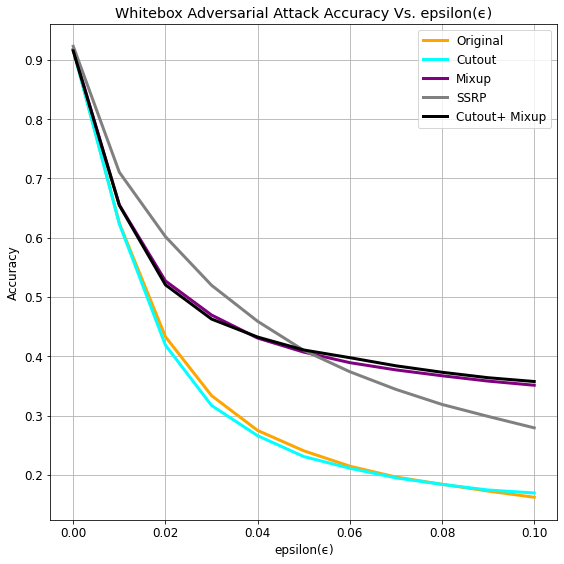

In [20]:
Attack_info_df = pd.read_csv('Whitebox_Adversarial_Attack_Accuracy_final.csv')
Attack_info_df['cutout_mixup_acc'] = cutout_mixup_FGSM_acc_list
Attack_info_df.to_csv('Whitebox_Adversarial_Attack_Accuracy_final.csv',index=False,encoding='utf-8')



plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8,8))
plt.plot(Attack_info_df['epsilon'], Attack_info_df['original_acc'],     color='orange',label='Original',lw=3, alpha=1)
plt.plot(Attack_info_df['epsilon'], Attack_info_df['cutout_acc'],       color='cyan',label='Cutout',lw=3, alpha=1)
plt.plot(Attack_info_df['epsilon'], Attack_info_df['mixup_acc'],        color='purple',label='Mixup',lw=3, alpha=1)
plt.plot(Attack_info_df['epsilon'], Attack_info_df['aux_rot_acc'],      color='gray',label='SSRP',lw=3, alpha=1)
plt.plot(Attack_info_df['epsilon'], Attack_info_df['cutout_mixup_acc'], color='black',label='Cutout+ Mixup',lw=3, alpha=1)
plt.xlabel('epsilon(ϵ)')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Whitebox Adversarial Attack Accuracy Vs. epsilon(ϵ)')
plt.legend()
plt.tight_layout()
plt.savefig('Whitebox_Adversarial_Attack_Accuracy_final.png',bbox_inches="tight",dpi=170)
plt.show()

